In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define the path where our dataset is stored

from google.colab import drive
# drive.mount('/content/drive')


# path = '/content/drive/My Drive/Colab Notebooks/Dataset'

# import os
# files = os.listdir(path)
# print(files)

dataset_path= '/content/drive/My Drive/Colab Notebooks/Dataset'

In [5]:
!git clone https://github.com/aniketshetty1nov/Machine_Learning_Projects.git
# Navigate to the cloned repository
# %cd Machine_Learning_Projects
path = '/content/Machine_Learning_Projects/Waste_Classification_Deep_learning/'

import os
files = os.listdir(path)
print(files)

dataset_path = '/content/Machine_Learning_Projects/Waste_Classification_Deep_learning/Trash_Dataset'

Cloning into 'Machine_Learning_Projects'...
remote: Enumerating objects: 8356, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 8356 (delta 4), reused 2 (delta 0), pack-reused 8343
Receiving objects: 100% (8356/8356), 378.18 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (18342/18342), done.
['combined_dataset', 'Trash_Dataset', 'Codes', 'WasteImagesDataset', 'readMe']


In [6]:
# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

In [7]:
# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

In [8]:
# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Determine if all images in the entore dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

metal folder contains 410 images.
trash folder contains 137 images.
plastic folder contains 482 images.
paper folder contains 594 images.
glass folder contains 501 images.
cardboard folder contains 403 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


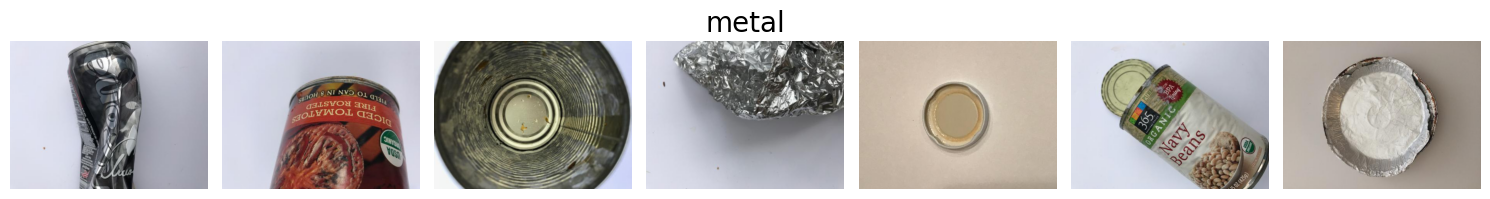

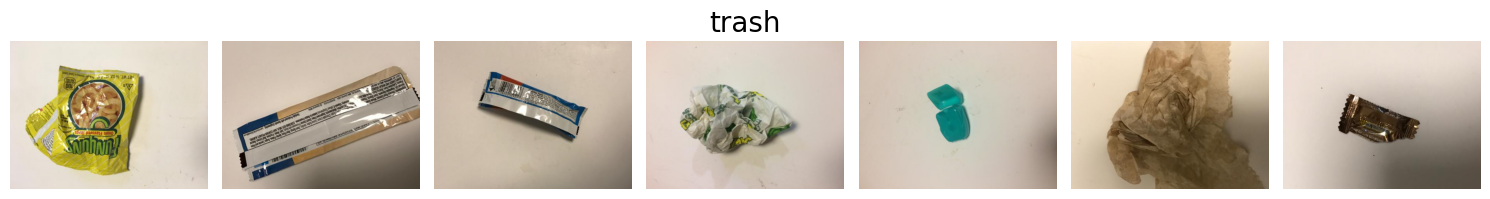

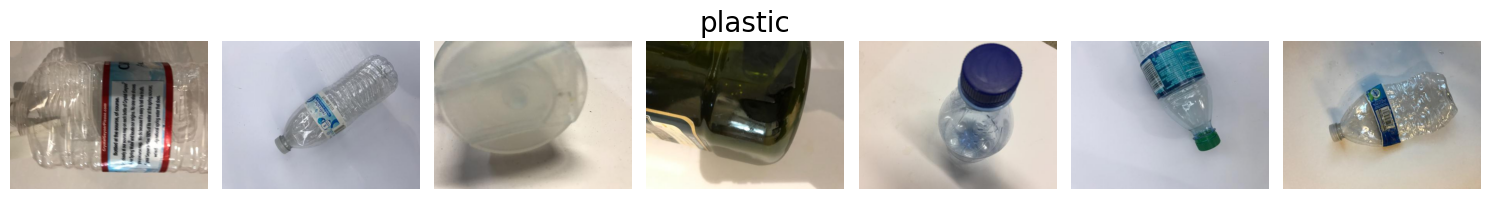

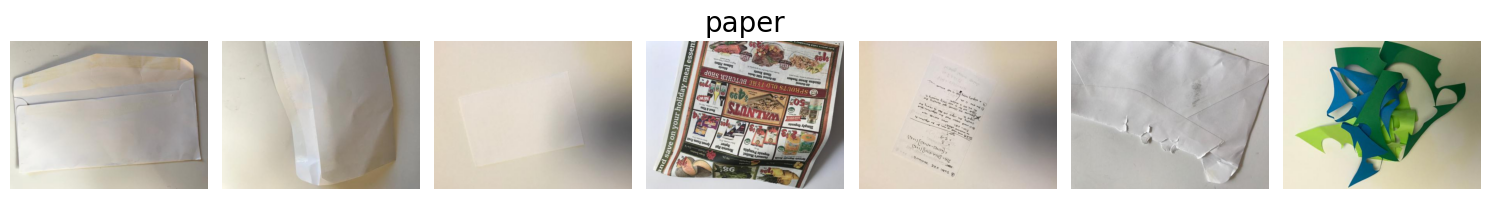

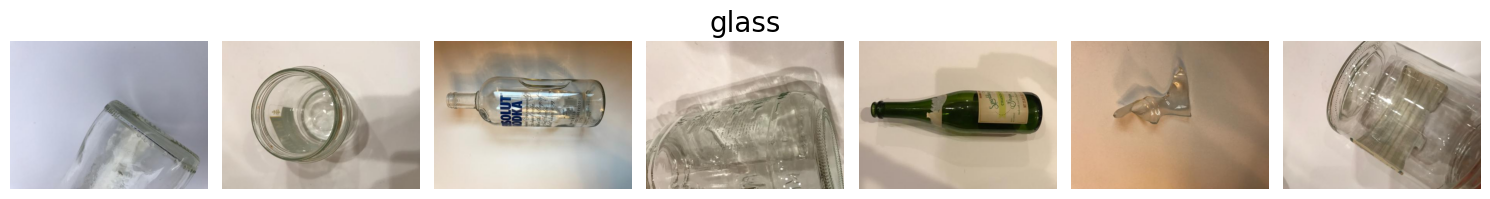

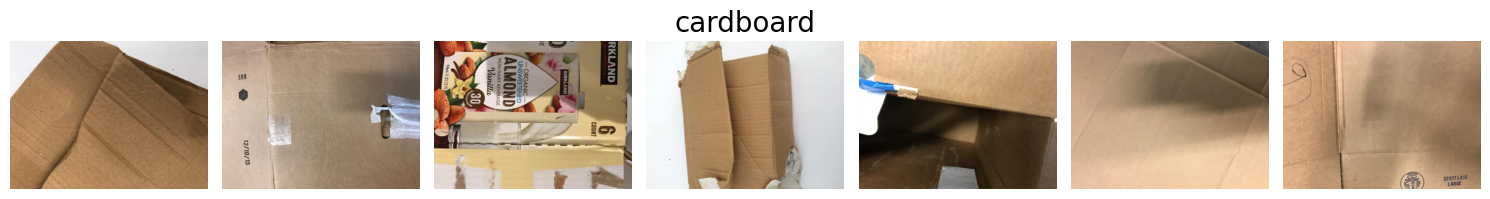

In [9]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:7]

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()


In [10]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,/content/Machine_Learning_Projects/Waste_Class...,metal
1,/content/Machine_Learning_Projects/Waste_Class...,metal
2,/content/Machine_Learning_Projects/Waste_Class...,metal
3,/content/Machine_Learning_Projects/Waste_Class...,metal
4,/content/Machine_Learning_Projects/Waste_Class...,metal


In [11]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")


Number of images in the training set: 2021
Number of images in the validation set: 506


In [12]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


In [13]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)


In [14]:
# Generating Batches of Image M
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)



Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [15]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [16]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [17]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [18]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [19]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [20]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    """
    Implement a residual block for ResNet architectures.

    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    kernel_size -- integer, kernel size of the middle convolutional layer in the main path
    filters     -- python list of integers, defining the number of filters in the CONV layers of the main path
    reduce      -- boolean, whether to reduce the spatial dimensions and increase depth;
                    if True, applies 1x1 CONV layer to the shortcut path.
    stride      -- integer, strides for the convolutional layer

    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We will need this later to add back to the main path.
    X_shortcut = X

    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    else:
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [21]:
def ResNet_50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Block 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Block 3
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Block 4
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Block 5
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)

    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [22]:
def Modified_ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Stage 3
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Stage 4
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)

    # Add Dropout to prevent overfitting
    X = Dropout(0.5)(X)

    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs = X_input, outputs = X, name='Modified_ResNet50')

    return model



In [23]:
# Define the shape of the input images and number of classes
input_shape = (384, 384, 3)
num_classes = 6

# Initialize the modified ResNet50 model with the specified parameters
modified_resnet50_model = Modified_ResNet50(input_shape=input_shape, classes=num_classes)


In [24]:
  # plot_model(modified_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)
#

In [23]:
# !apt-get -qq install -y graphviz && pip install -q pydot==1.4.2

In [25]:
modified_resnet50_model.summary()

Model: "Modified_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 384, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 189, 189, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 189, 189, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 189, 189, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 94, 94, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 94, 94, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 94, 94, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 94, 94, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 94, 94, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 94, 94, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 94, 94, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 94, 94, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 94, 94, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 94, 94, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 94, 94, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 94, 94, 256)    │              0 │ batch_normalization_4… │
│                           │                        │                │ batch_normalization_2… │
├──────────────────────

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [26]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True, verbose=1)



In [27]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [28]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [ ]:
# Total number of epochs
num_epochs = 50
modified_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = modified_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/50
 7/64 ━━━━━━━━━━━━━━━━━━━━ 1:15:23 79s/step - accuracy: 0.2627 - loss: 4.1305

In [ ]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')


    plt.show()

plot_learning_curves(history)



In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()



In [ ]:
evaluate_model_performance(modified_resnet50_model, val_generator, class_labels)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_training_data'

In [2]:
!git clone https://github.com/aniketshetty1nov/Machine_Learning_Projects.git
# Navigate to the cloned repository
# %cd Machine_Learning_Projects
path = '/content/Machine_Learning_Projects/Waste_Classification_Deep_learning/'

import os
files = os.listdir(path)
print(files)

dataset_path = '/content/Machine_Learning_Projects/Waste_Classification_Deep_learning/Trash_Dataset'

Cloning into 'Machine_Learning_Projects'...
remote: Enumerating objects: 8356, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 8356 (delta 4), reused 2 (delta 0), pack-reused 8343
Receiving objects: 100% (8356/8356), 378.18 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (18342/18342), done.
['Codes', 'WasteImagesDataset', 'combined_dataset', 'readMe', 'Trash_Dataset']


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed, LSTM
from keras.src.legacy.preprocessing.image import ImageDataGenerator

In [4]:
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [5]:
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50
LATENT_DIM = 100  # Dimension of the random noise
NUM_CLASSES = 7  # Number of classes

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(dataset_path,
                                                            shuffle=True,
                                                            image_size=(IMG_SIZE, IMG_SIZE),
                                                            batch_size=BATCH_SIZE)

'''
# Function to resize and preprocess images
def preprocess_images(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Example: Load and preprocess your dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'path_to_train_data',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    label_mode=None
).map(preprocess_images)'''

Found 2527 files belonging to 6 classes.


"\n# Function to resize and preprocess images\ndef preprocess_images(image):\n    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))\n    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]\n    return image\n\n# Example: Load and preprocess your dataset\ntrain_ds = tf.keras.preprocessing.image_dataset_from_directory(\n    'path_to_train_data',\n    batch_size=BATCH_SIZE,\n    image_size=(IMG_SIZE, IMG_SIZE),\n    label_mode=None\n).map(preprocess_images)"

In [8]:
class_names=dataset.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [9]:
len(dataset)

79

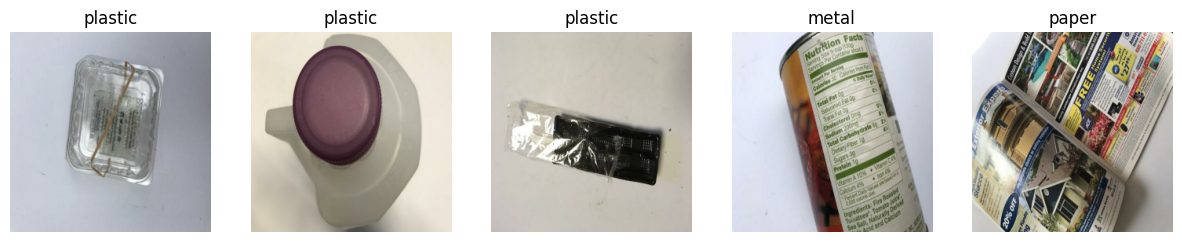

In [10]:
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
    for i in range(5):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [12]:
# Function to spilt the Data

In [13]:
train_size=0.8
(len(dataset)*(train_size))

63.2

In [14]:
train_ds=dataset.take(14)
len(train_ds)

14

In [15]:
test_ds=dataset.skip(14)
len(test_ds)

65

In [16]:
val_size=0.1
(len(dataset)*val_size)


7.9

In [17]:
val_ds=test_ds.take(1)
len(val_ds)

1

In [18]:
test_ds=test_ds.skip(1)
len(test_ds)

64

In [19]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)


    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [20]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

63

In [22]:
len(val_ds)

7

In [23]:
len(test_ds)

9

In [27]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale=tf.keras.Sequential([
     tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
     tf.keras.layers.Rescaling(1./255)
])

In [31]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


# Assume your dataset is already split into train_ds, val_ds, and test_ds
# Normalize the datasets
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))


In [32]:
# Define the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [33]:
# Freeze the base_model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 547ms/step - accuracy: 0.2441 - loss: 1.9899 - val_accuracy: 0.3125 - val_loss: 1.6229
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 410ms/step - accuracy: 0.2729 - loss: 1.6880 - val_accuracy: 0.3304 - val_loss: 1.6185
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 390ms/step - accuracy: 0.3152 - loss: 1.6351 - val_accuracy: 0.3304 - val_loss: 1.6168
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 383ms/step - accuracy: 0.3088 - loss: 1.6263 - val_accuracy: 0.3214 - val_loss: 1.6191
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - accuracy: 0.3058 - loss: 1.6194 - val_accuracy: 0.3304 - val_loss: 1.5905
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.3497 - loss: 1.5955 - val_accuracy: 0.2902 - val_loss: 1.6252
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.3303 - loss: 1.6038 - val_accuracy: 0.3884 - val_loss: 1.5442
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 382ms/step - accuracy: 0.3471 - loss: 1.5415 - val_accu

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, RandomRotation, RandomZoom, RandomFlip

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomFlip("horizontal")
])

# Apply data augmentation to your datasets
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds_augmented = val_ds.map(lambda x, y: (data_augmentation(x, training=False), y))
test_ds_augmented = test_ds.map(lambda x, y: (data_augmentation(x, training=False), y))


In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base_model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune some layers
for layer in model.layers[-10:]:
    layer.trainable = True

# Recompile the model after fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds_augmented,
    validation_data=val_ds_augmented,
    epochs=50
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds_augmented)
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 755ms/step - accuracy: 0.2056 - loss: 1.8506 - val_accuracy: 0.2500 - val_loss: 1.8387
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 703ms/step - accuracy: 0.2431 - loss: 1.7420 - val_accuracy: 0.1518 - val_loss: 1.8045
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 725ms/step - accuracy: 0.2336 - loss: 1.7350 - val_accuracy: 0.1518 - val_loss: 1.7825
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 704ms/step - accuracy: 0.2309 - loss: 1.7416 - val_accuracy: 0.2500 - val_loss: 1.7480
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 716ms/step - accuracy: 0.2356 - loss: 1.7400 - val_accuracy: 0.2500 - val_loss: 1.7341
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 701ms/step - accuracy: 0.2327 - loss: 1.7388 - val_accuracy: 0.2500 - val_loss: 1.7405
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 717ms/step - accuracy: 0.2466 - loss: 1.7231 - val_accuracy: 0.2500 - val_loss: 1.7373
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 706ms/step - accuracy: 0.2291 - loss: 1.7417 - val_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomRotation, RandomZoom, RandomFlip, Rescaling, Resizing
from tensorflow.keras.models import Model

# Define constants
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 7

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
    Rescaling(1./255)
])

# Apply data augmentation to datasets
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds_augmented = val_ds.map(lambda x, y: (data_augmentation(x, training=False), y))
test_ds_augmented = test_ds.map(lambda x, y: (data_augmentation(x, training=False), y))

# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base_model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1
)

# Train the model
history = model.fit(
    train_ds_augmented,
    validation_data=val_ds_augmented,
    epochs=50,
    callbacks=[lr_scheduler]
)

# Fine-tune some layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(
    train_ds_augmented,
    validation_data=val_ds_augmented,
    epochs=20,  # Additional epochs for fine-tuning
    callbacks=[lr_scheduler]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds_augmented)
print(f'Test Accuracy: {test_accuracy}')


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 743ms/step - accuracy: 0.1705 - loss: 2.0824 - val_accuracy: 0.2500 - val_loss: 1.7451 - learning_rate: 1.0000e-04
Epoch 2/50
